In [1]:
import xarray as xr
import rioxarray as rioxr

import geopandas as geopd
import pandas as pd

import numpy as np

import os
import pathlib

from parallelbar import progress_map



import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"]  = 400
plt.style.use('dark_background')

In [2]:
def mean_era5_land_evap(args):
    """ Fetches the daily evaporation accumulation of the given watersheds, over the time period of one year (and one file)
    Does not return anything, instead writes the result to a csv file of shape (timesteps, catchments)
    Please note that ERA5-Land gives evaporation as the total accumulation since last midnight, meaning that time 00:00 is actually the evaporation total of the previous day. 
    https://confluence.ecmwf.int/display/CKB/ERA5-Land%253A+data+documentation#ERA5Land
    That differs from ERA5.
    """
    src_path,  dst_path, watersheds = args
    
    weather = pd.DataFrame(index=pd.to_datetime([]), columns=watersheds.Paikka_Id)
    weather.index.name = 'date'

    with rioxr.open_rasterio(src_path, mask_and_scale=True) as data_array:
        

        data_array = data_array.rio.write_crs("epsg:4326")
        
        # force load all data to memory, important for the supercomputer
        #data_array = data_array.load()
        # iterating over the days in the file 
        for time_step in data_array.valid_time:
            time = time_step.item()

            is_last = str(time) == '2023-12-31 23:00:00'
                
            # skipping all non-midnight entries, because midnight contains entire evaporation of the previous day
            if time.hour != 0:
                # Special case for the last value in timeseries
                if not is_last:
                    continue
                
            one_day_data = data_array.sel({'valid_time':time})

            row = []
            # looks a bit unpythonic but DataFrame.iterrows returns series, not dataframes and it's a hassle to change back
            for i in range(len(watersheds)): 
                watershed = watersheds.iloc[[i]]
                place_id = watershed.Paikka_Id[i]
                
                # Calculating the average of the attribute for the whole catchment
                clipped = one_day_data.rio.clip(watershed.geometry.values, crs=watershed.crs, all_touched=True)
                average = clipped.mean().item()

                """ ERA5 uses meters and evaporation is marked as negative (precipitation is positive)
                This changes that to positive mm, as previous camels use
                """
                average *= -1000
                
                average = round(average, 2)
                

                row.append(average)
            # sifting time by one day because midnight contains previous day's accumulation, and saving the result row to that date.
            if not is_last:
                weather.loc[pd.to_datetime(str(time)) + pd.tseries.offsets.DateOffset(-1)] = row
            else: 
                weather.loc[str(time)] = row

    weather.to_csv(dst_path)
    # only for debuggin purposes
    #return weather

def mean_weather_era5_evap(args):
    """ Calculates the daily mean of the given watersheds for one variable, over the time period of one year (and one file)
    Does not return anything, instead writes the result to a csv file of shape (timesteps, catchments)
    """
    src_path,  dst_path, watersheds = args

    weather = pd.DataFrame(index=pd.to_datetime([]), columns=watersheds.Paikka_Id)
    weather.index.name = 'date'

    with rioxr.open_rasterio(src_path, mask_and_scale=True) as data_array:
        # resampling from hourly to daily values. Sum because evaporation is accumulative
        data_array = data_array.resample(valid_time='1D').sum()

        data_array = data_array.rio.write_crs("epsg:4326")
        
        # force load all data to memory, important for the supercomputer
        #data_array = data_array.load()
        # iterating over the days in the file 
        for time_step in data_array.valid_time:
            time = time_step.item()
            one_day_data = data_array.sel({'valid_time':time})

            row = []
            # looks a bit unpythonic but DataFrame.iterrows returns series, not dataframes and it's a hassle to change back
            for i in range(len(watersheds)): 
                watershed = watersheds.iloc[[i]]
                place_id = watershed.Paikka_Id[i]
                
                # Calculating the average of the attribute for the whole catchment
                clipped = one_day_data.rio.clip(watershed.geometry.values, crs=watershed.crs, all_touched=True)
                average = clipped.mean().item()

                """ ERA5 uses meters and evaporation is marked as negative (precipitation is positive)
                This changes that to positive mm, as previous camels use
                """
                average *= -1000
                
                average = round(average, 2)
                

                row.append(average)
            weather.loc[str(time)] = row

    weather.to_csv(dst_path)
    # only for debuggin purposes
    #return weather

def mean_weather_era5_swe(args):
    """ Calculates the daily mean of the given watersheds for one variable, over the time period of one year (and one file)
    Does not return anything, instead writes the result to a csv file of shape (timesteps, catchments)
    """
    src_path,  dst_path, watersheds = args

    weather = pd.DataFrame(index=pd.to_datetime([]), columns=watersheds.Paikka_Id)
    weather.index.name = 'date'

    with rioxr.open_rasterio(src_path, mask_and_scale=True) as data_array:
        # resampling from hourly to daily values. Mean because swe is a storage quantity
        data_array = data_array.resample(valid_time='1D').mean()

        data_array = data_array.rio.write_crs("epsg:4326")
        
        # force load all data to memory, important for the supercomputer
        #data_array = data_array.load()
        # iterating over the days in the file 
        for time_step in data_array.valid_time:
            time = time_step.item()
            one_day_data = data_array.sel({'valid_time':time})

            row = []
            # looks a bit unpythonic but DataFrame.iterrows returns series, not dataframes and it's a hassle to change back
            for i in range(len(watersheds)): 
                watershed = watersheds.iloc[[i]]
                place_id = watershed.Paikka_Id[i]
                
                # Calculating the average of the attribute for the whole catchment
                clipped = one_day_data.rio.clip(watershed.geometry.values, crs=watershed.crs, all_touched=True)
                average = clipped.mean().item()
                # changing from meters to mm
                average *= 1000
                average = round(average, 2)
                

                row.append(average)
            weather.loc[str(time)] = row

    weather.to_csv(dst_path)

In [3]:
vector_watershed_path = "/home/iielse/Documents/DIWA/data/CAMELS-FI catchments/CAMELS-FI_catchments.gpkg"
watersheds = geopd.read_file(vector_watershed_path, layer='v1')
watersheds = watersheds.to_crs(epsg=4326)

root = os.getcwd()

src_dir = os.path.join(root, "data")

src_path = pathlib.Path(src_dir)

dst_root = os.path.join(root, "csv")

pet_dir = os.path.join(dst_root, 'pet')

snow_e_dir = os.path.join(dst_root, 'snow_evaporation')

swe_dir = os.path.join(dst_root, 'swe')

create_dirs = [pet_dir, snow_e_dir, swe_dir]

for directory in create_dirs:
    if not os.path.exists(directory):
        os.makedirs(directory)

pet_files = [item for item in src_path.iterdir() if 'potential_evaporation' in os.path.basename(item) ]
#snow_e_files = [item for item in src_path.iterdir() if 'snow_evaporation' in os.path.basename(item) ]
#swe_files = [item for item in src_path.iterdir() if 'snow_depth' in os.path.basename(item)]



pet_args_list = []
for src_path in pet_files:
    dst_path = os.path.join(pet_dir, src_path.stem + '.csv')
    # Skipping already existing ones
    if os.path.exists(dst_path):
        continue
    pet_args_list.append((src_path,  dst_path, watersheds))
    
"""
snow_e_args_list = []
for src_path in snow_e_files:
    dst_path = os.path.join(snow_e_dir, src_path.stem + '.csv')
    # Skipping already existing ones
    if os.path.exists(dst_path):
        continue
    snow_e_args_list.append((src_path,  dst_path, watersheds))


swe_args_list = []
for src_path in swe_files:
    dst_path = os.path.join(swe_dir, src_path.stem + '.csv')
    # Skipping already existing ones
    if os.path.exists(dst_path):
        continue
    swe_args_list.append((src_path,  dst_path, watersheds))
"""


none_catcher = progress_map(mean_era5_land_evap, pet_args_list, n_cpu=18)
#progress_map(mean_weather_era5_evap, snow_e_args_list, n_cpu=18)
#progress_map(mean_weather_era5_swe, swe_args_list, n_cpu=18)

DONE:   0%|          | 0/720 [00:00<?, ?it/s]

In [21]:
src_path = "data/2023-12-potential_evaporation.nc"

with rioxr.open_rasterio(src_path, mask_and_scale=True) as data_array:
        # resampling from hourly to daily values. Sum because evaporation is accumulative
        #data_array = data_array.resample(valid_time='1D').sum()

        data_array = data_array.rio.write_crs("epsg:4326")
        
        # force load all data to memory, important for the supercomputer
        #data_array = data_array.load()
        # iterating over the days in the file 
        for time_step in data_array.valid_time:
            time = time_step.item()
            # skipping all non-midnight entries, because midnight contains entire evaporation of the previous day
            if time.hour != 0:
                # Special case for the last value in timeseries
                if str(time) != '2023-12-31 23:00:00':
                    last_value = True
                    continue
            print(time)
            
            #one_day_data = data_array.sel({'valid_time':time})
            

2023-12-01 00:00:00
2023-12-02 00:00:00
2023-12-03 00:00:00
2023-12-04 00:00:00
2023-12-05 00:00:00
2023-12-06 00:00:00
2023-12-07 00:00:00
2023-12-08 00:00:00
2023-12-09 00:00:00
2023-12-10 00:00:00
2023-12-11 00:00:00
2023-12-12 00:00:00
2023-12-13 00:00:00
2023-12-14 00:00:00
2023-12-15 00:00:00
2023-12-16 00:00:00
2023-12-17 00:00:00
2023-12-18 00:00:00
2023-12-19 00:00:00
2023-12-20 00:00:00
2023-12-21 00:00:00
2023-12-22 00:00:00
2023-12-23 00:00:00
2023-12-24 00:00:00
2023-12-25 00:00:00
2023-12-26 00:00:00
2023-12-27 00:00:00
2023-12-28 00:00:00
2023-12-29 00:00:00
2023-12-30 00:00:00
2023-12-31 00:00:00
2023-12-31 23:00:00


In [23]:

is_last = str(time) == '2023-12-31 23:00:00'
is_last

True

In [15]:
pd.to_datetime(str(time)) + pd.tseries.offsets.DateOffset(-1)

Timestamp('1961-02-28 00:00:00')

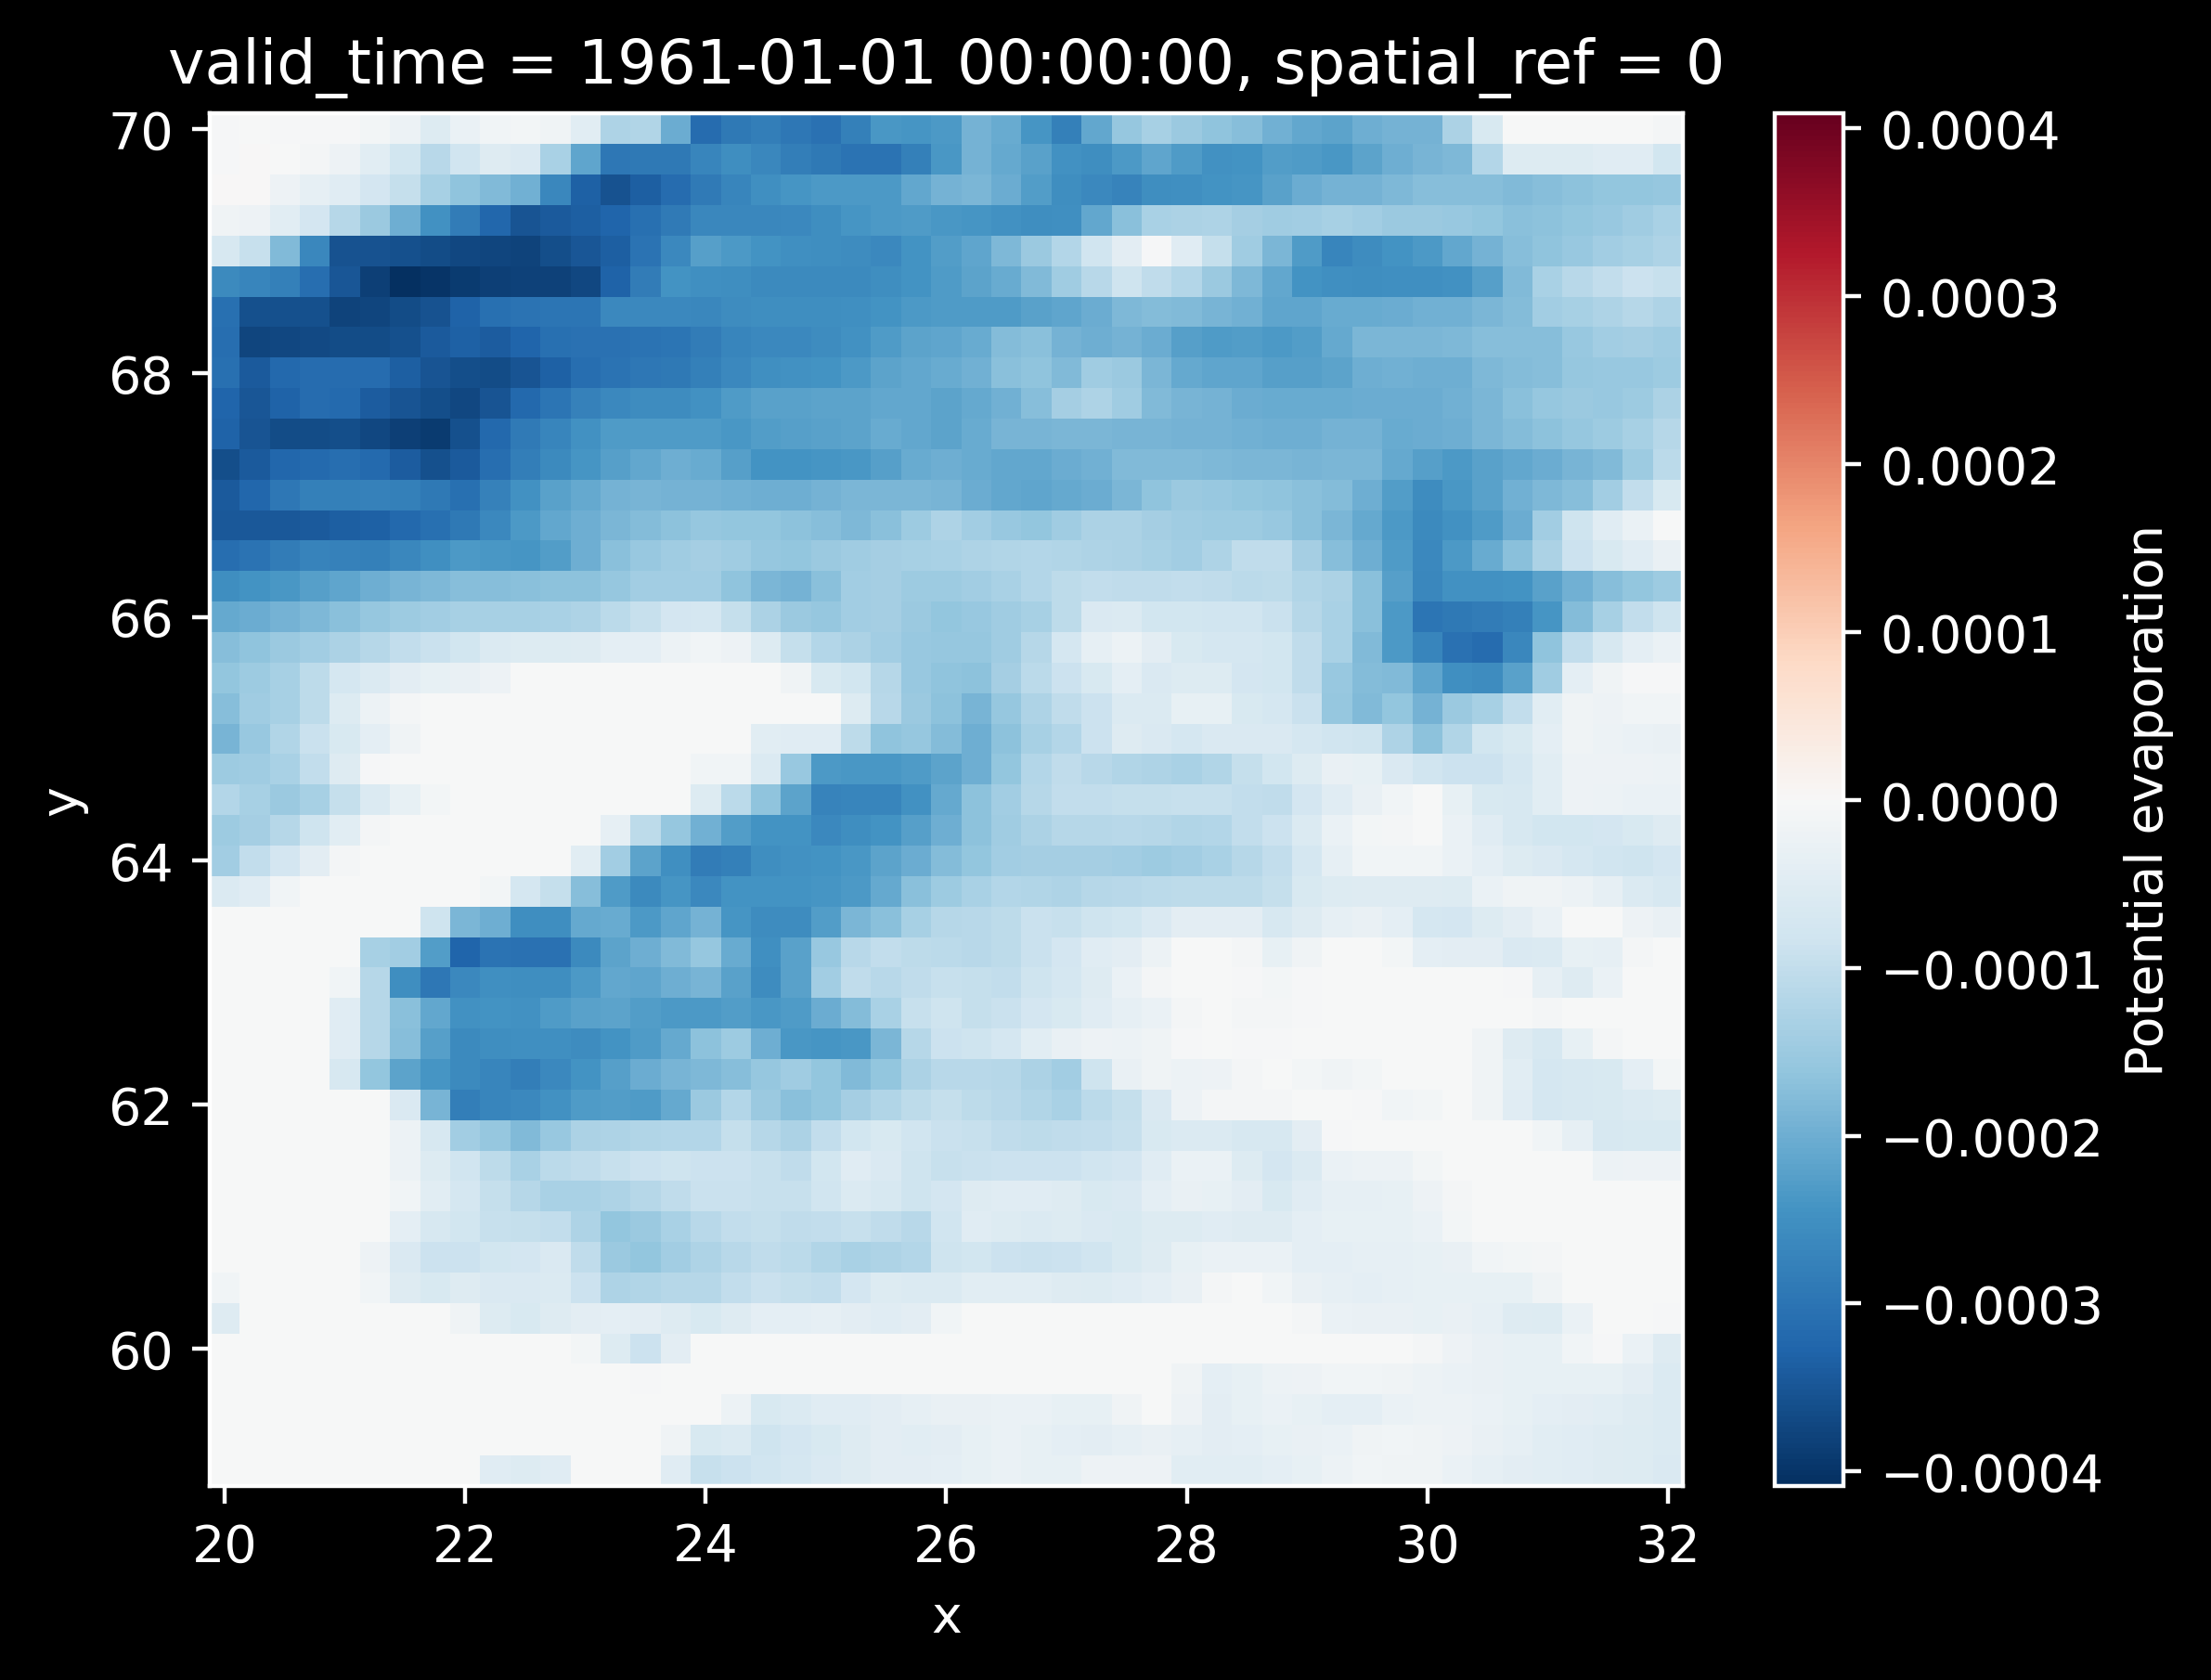

In [8]:

qm = one_day_data.plot(cbar_kwargs={'label': one_day_data.long_name})

In [32]:
i= 0
watershed = watersheds.iloc[[i]]
with rioxr.open_rasterio(src_path, mask_and_scale=True) as data_array:
    data_array = data_array.resample(valid_time='1D').sum()

    data_array = data_array.rio.write_crs("epsg:4326")
    
    # force load all data to memory, important for the supercomputer
    #data_array = data_array.load()
    # iterating over the days in the file 
    for time_step in data_array.valid_time:
        time = time_step.item()
        one_day_data = data_array.sel({'valid_time':time})
        
        break

-0.00020948391465935856


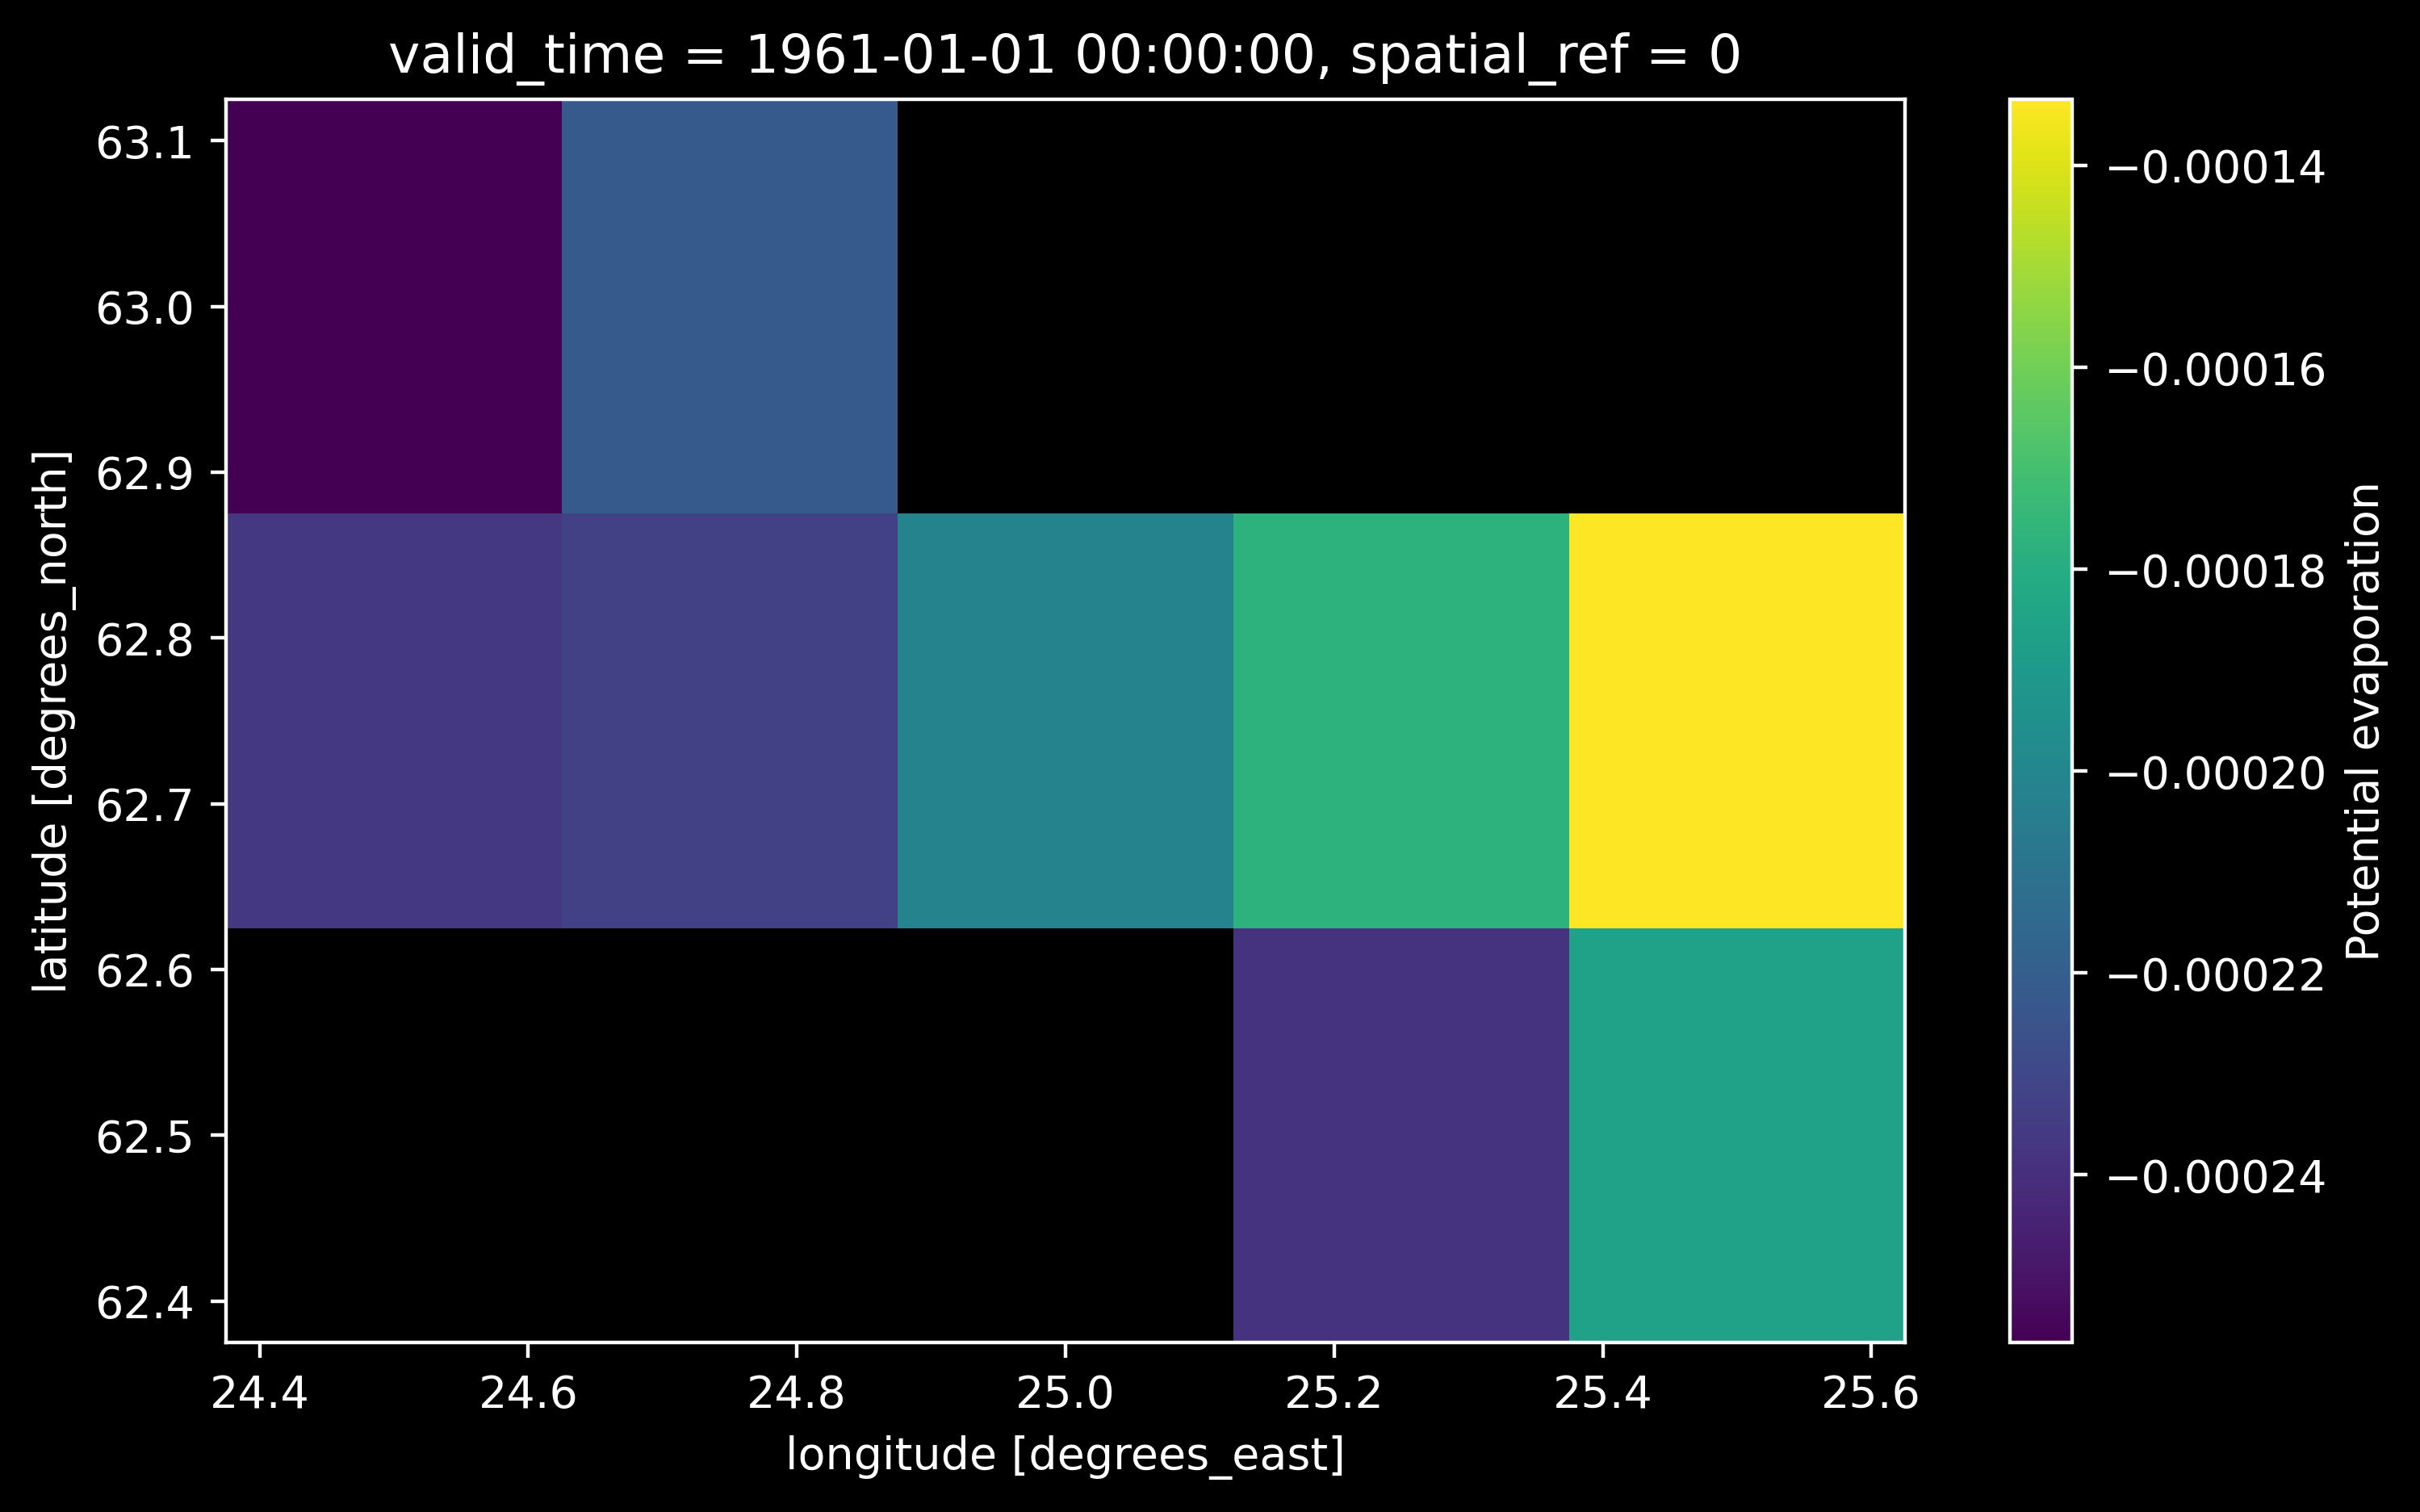

In [38]:
bounds = watershed.bounds
minx = bounds.at[i, 'minx']
maxx = bounds.at[i, 'maxx']
miny = bounds.at[i, 'miny']
maxy = bounds.at[i, 'maxy']
aspect = (maxx-minx) / (maxy-miny)
print(one_day_data.rio.clip(watershed.geometry.values).mean().item())
qm = one_day_data.rio.clip(watershed.geometry.values, crs=watershed.crs).plot(aspect=aspect, size=5, cbar_kwargs={'label': one_day_data.long_name})

In [35]:
one_day_data

<xarray.DataArray 'pev' (y: 45, x: 49)> Size: 9kB
array([[-6.2088948e-06, -2.4912879e-08, -4.6144705e-06, ...,
        -5.4715201e-08, -5.4715201e-08, -7.2668772e-06],
       [-4.7187787e-06,  1.5695114e-06, -3.0945521e-06, ...,
        -4.9750088e-05, -5.0659059e-05, -7.8390120e-05],
       [ 1.1671800e-06,  9.5856376e-07, -2.0409701e-05, ...,
        -1.6098726e-04, -1.5978026e-04, -1.5848386e-04],
       ...,
       [-5.4715201e-08, -5.4715201e-08, -5.4715201e-08, ...,
        -4.5145629e-05, -5.2521704e-05, -5.8020232e-05],
       [-5.4715201e-08, -5.4715201e-08, -5.4715201e-08, ...,
        -5.1106093e-05, -5.5978773e-05, -5.9286831e-05],
       [-5.4715201e-08, -5.4715201e-08, -5.4715201e-08, ...,
        -5.3579686e-05, -5.6992052e-05, -6.0732244e-05]], dtype=float32)
Coordinates:
  * x            (x) float64 392B 20.0 20.25 20.5 20.75 ... 31.5 31.75 32.0
  * y            (y) float64 360B 70.0 69.75 69.5 69.25 ... 59.5 59.25 59.0
    valid_time   object 8B 1961-01-01 00:00:00
    spatial_ref  int64 8B 0
Attributes: (12/51)
    latitude#long_name:                       latitude
    latitude#standard_name:                   latitude
    latitude#stored_direction:                decreasing
    latitude#units:                           degrees_north
    latitude#_FillValue:                      nan
    longitude#long_name:                      longitude
    ...                                       ...
    GRIB_units:                               m
    long_name:                                Potential evaporation
    units:                                    ('m', 'm', 'm', 'm', 'm', 'm', ...
    standard_name:                            unknown
    GRIB_surface:                             0
    coordinates:                              number valid_time latitude long...

<Axes: >

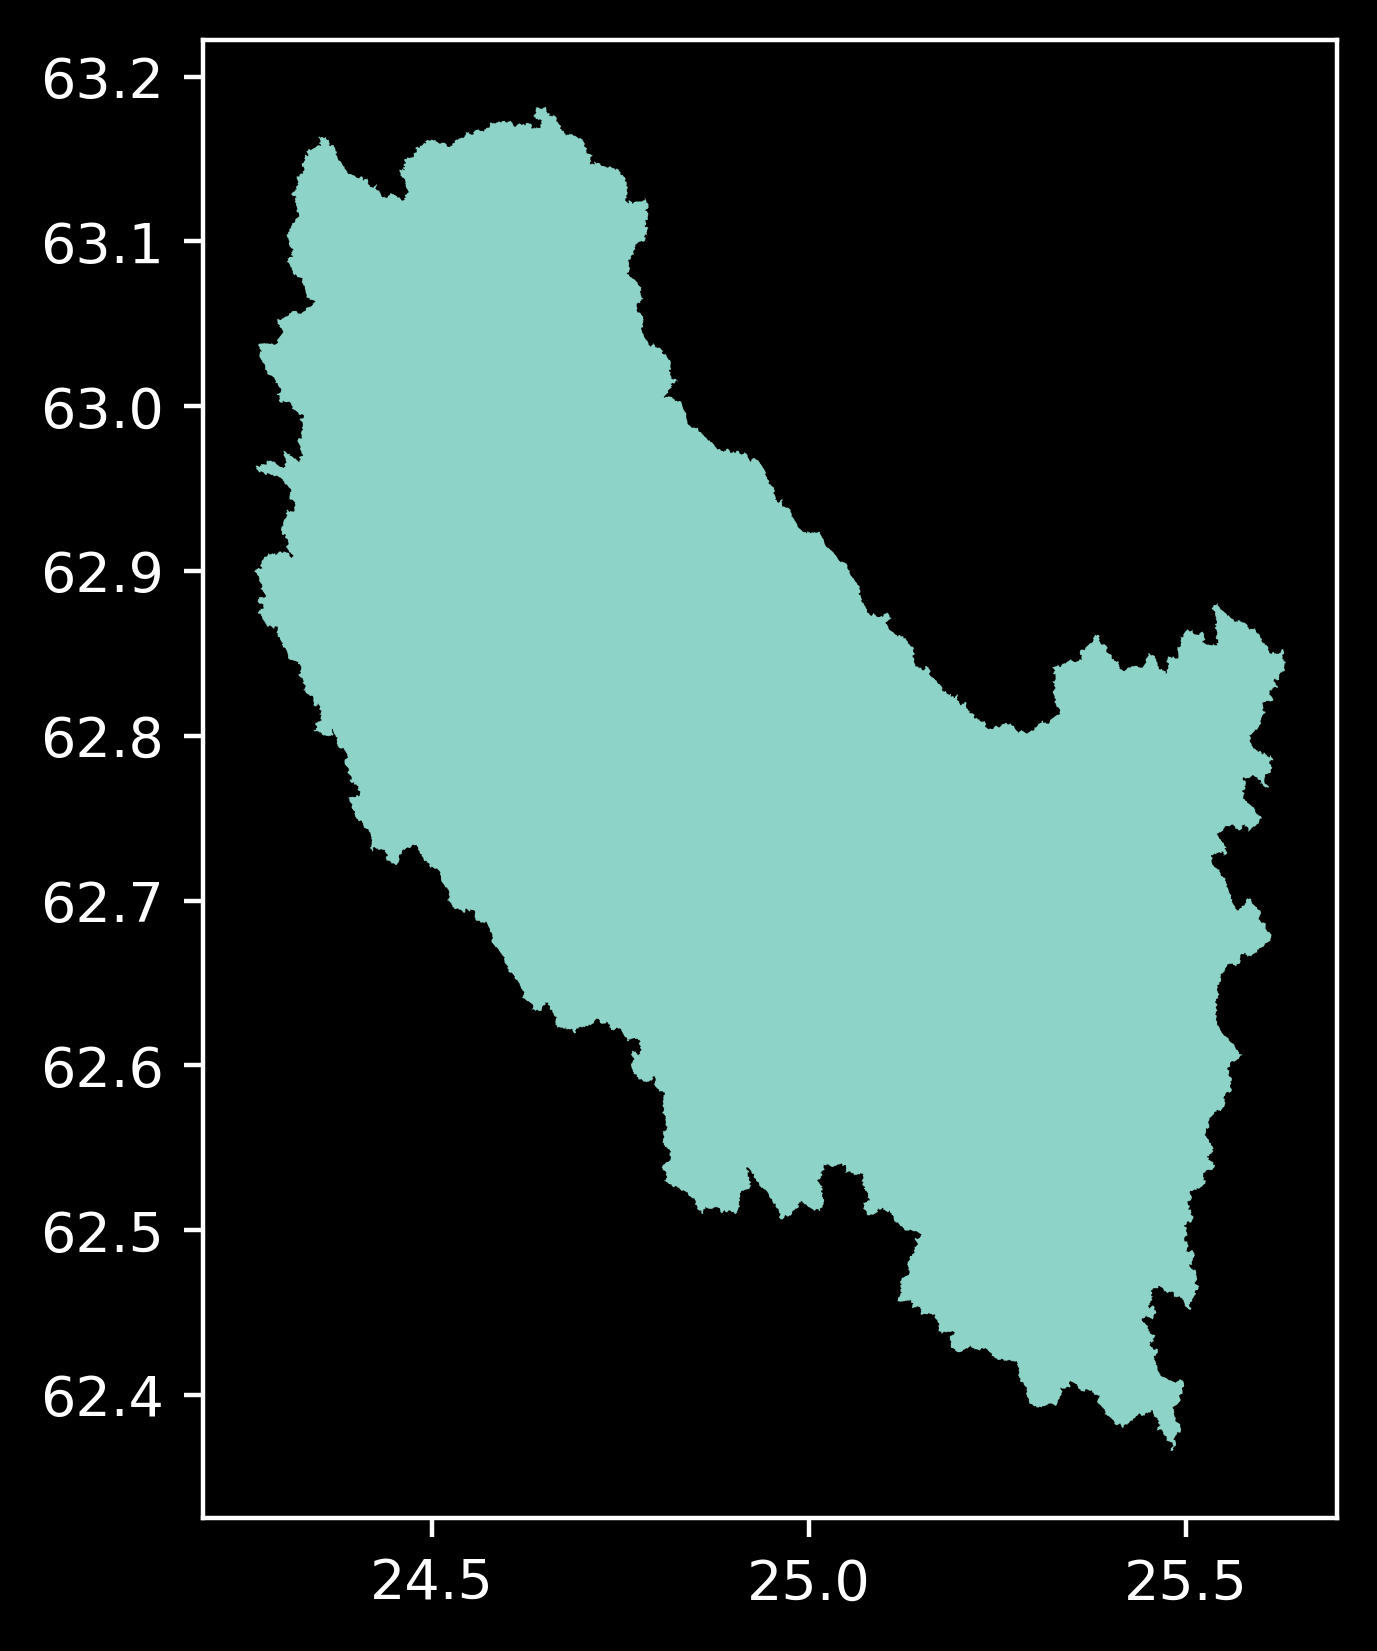

In [34]:
watershed.plot()

In [29]:
arr

<xarray.DataArray 'pev' (valid_time: 744, y: 45, x: 49)> Size: 7MB
array([[[-3.4342520e-07, -7.5204298e-08, -7.3085539e-07, ...,
         -1.5599653e-08, -1.5599653e-08, -2.8382055e-07],
        [-3.7322752e-07, -1.0500662e-07, -7.6065771e-07, ...,
         -9.3947165e-07, -9.9907629e-07, -2.0421576e-06],
        [ 4.4004992e-08,  1.4202669e-08, -1.3269018e-06, ...,
         -3.0256342e-06, -2.9958319e-06, -2.9660296e-06],
        ...,
        [-1.5599653e-08, -1.5599653e-08, -1.5599653e-08, ...,
         -1.1182856e-06, -1.2970995e-06, -1.4461111e-06],
        [-1.5599653e-08, -1.5599653e-08, -1.5599653e-08, ...,
         -1.1480879e-06, -1.2672972e-06, -1.3865065e-06],
        [-1.5599653e-08, -1.5599653e-08, -1.5599653e-08, ...,
         -1.0586809e-06, -1.2076925e-06, -1.3865065e-06]],

       [[-3.2037497e-07, -2.2351742e-08, -4.6938658e-07, ...,
          7.4505806e-09,  7.4505806e-09, -2.9057264e-07],
        [-2.9057264e-07, -2.2351742e-08, -4.6938658e-07, ...,
         -9.1642141e-07, -1.0058284e-06, -2.0489097e-06],
        [ 3.7252903e-08,  7.4505806e-09, -1.3634562e-06, ...,
         -2.9429793e-06, -2.9429793e-06, -2.9131770e-06],
...
        [ 4.8894435e-09,  4.8894435e-09,  4.8894435e-09, ...,
         -1.4405232e-06, -1.5597325e-06, -1.6789418e-06],
        [ 4.8894435e-09,  4.8894435e-09,  4.8894435e-09, ...,
         -1.4554244e-06, -1.5448313e-06, -1.5895348e-06],
        [ 4.8894435e-09,  4.8894435e-09,  4.8894435e-09, ...,
         -1.0828953e-06, -1.1126976e-06, -1.1574011e-06]],

       [[-3.7136488e-07, -4.9057417e-07, -1.4442485e-06, ...,
         -1.3737008e-08, -1.3737008e-08, -2.8195791e-07],
        [-9.6741132e-07, -1.1164229e-06, -2.0402949e-06, ...,
          1.6065314e-08, -6.0978346e-07, -1.7124694e-06],
        [-1.3250392e-06, -2.1595042e-06, -4.0966552e-06, ...,
         -5.2037649e-07, -1.1164229e-06, -1.7124694e-06],
        ...,
        [-1.3737008e-08, -1.3737008e-08, -1.3737008e-08, ...,
         -8.4820203e-07, -9.9721365e-07, -1.1164229e-06],
        [-1.3737008e-08, -1.3737008e-08, -1.3737008e-08, ...,
         -9.9721365e-07, -1.0866206e-06, -1.1164229e-06],
        [-1.3737008e-08, -1.3737008e-08, -1.3737008e-08, ...,
         -1.0270160e-06, -1.0270160e-06, -1.0270160e-06]]], dtype=float32)
Coordinates:
  * x            (x) float64 392B 20.0 20.25 20.5 20.75 ... 31.5 31.75 32.0
  * y            (y) float64 360B 70.0 69.75 69.5 69.25 ... 59.5 59.25 59.0
  * valid_time   (valid_time) object 6kB 1961-01-01 00:00:00 ... 1961-01-31 2...
    spatial_ref  int64 8B 0
Attributes: (12/51)
    latitude#long_name:                       latitude
    latitude#standard_name:                   latitude
    latitude#stored_direction:                decreasing
    latitude#units:                           degrees_north
    latitude#_FillValue:                      nan
    longitude#long_name:                      longitude
    ...                                       ...
    GRIB_units:                               m
    long_name:                                Potential evaporation
    units:                                    ('m', 'm', 'm', 'm', 'm', 'm', ...
    standard_name:                            unknown
    GRIB_surface:                             0
    coordinates:                              number valid_time latitude long...